# Analisi di spettrogrammi audio

In questo notebook viene eseguita un'analisi sugli spettrogrammi di alcuni audio. L'obiettivo è estrarre informazioni utili dagli spettrogrammi e rappresentarle graficamente. 

## Importazione delle librerie necessarie
Si installano e importano le librerie necessarie per l'analisi e la visualizzazione dei dati. 

In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Importazione del dataset
Importiamo anche il dataset dalla quale prenderemo gli audio. Questo passaggio l'abbiamo già visto nel notebook precedente dove abbiamo effettuato un'analisi esplorativa.

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


## Funzioni per il processamento dei dati
I dati a nostra disposizione sono dei **file .wav** perciò è necessario definire delle funzioni per convertirli in spettrogrammi.

La prima funzione definita è `squeeze(audio, labels)`, la quale prende come argomenti l'audio e le classi.

Questa funzione serve per rimuovere l'ultimo asse dello shape dai nostri audio. Attualmente, lo shape dei dati, come abbiamo potuto analizzare nel notebook sulol'analisi esplorativa, è (32, 16000, 1), ma si può eliminare l'ultima dimensione poiché non necessaria. Specificando il parametro **axis=-1** nella funzione `tf.squeeze` la forma dell'audio viene trasformata in (32, 16000).

Eseguiamo questa semplificazione sulla forma del dato poiché rende la fase di processamento dei dati più efficiente, soprattutto per quando andremo a utilizzare un modello.

In [3]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [4]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Come è possibile notare, adesso la forma dell'audio è (32, 16000).

### Conversione dataset
Definiamo altre due funzioni: `get_spectrogram` e `get_spectrogram_dataset`. Quest'ultime usate insieme convertono il nostro dataset di audio in un dataset di spettrogrammi. La prima funzione `get_spectrogram` converte il singolo audio in spettrogramma mentre la seconda funzione `get_spectrogram_dataset` richiama la prima funzione per ogni dato presente nel dataset.

In [5]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Infine definiamo la funzione `samplefy(train_ds, dir_label)`, che prende in input un dataset e una label. Questa funzione è necessaria per ricavare un audio, o nel nostro caso uno spettrogramma, appartenente a una specifica classe.

In [6]:
def samplefy(train_ds, dir_label):
    for audio, label in train_ds:
        label_np = label.numpy()
        
        for i in range(len(label_np)):
            if label_names[label_np[i]] == dir_label:
                spectrogram = np.squeeze(audio[i], axis=-1)
                spectrogram = np.log(spectrogram + np.finfo(float).eps)  # aggiungiamo una piccola costante per evitare problemi con log(0)
                return spectrogram, label_names[label_np[i]]

## Visualizzazione spettrogrammi
La funzione `plot_spectrograms` racchiude tutti i comandi utili per la visualizzazione dei dati. Quando chiamata, utilizza la funzione precedentemente creata per estrarre le informazioni di quattro diversi audio.

In [7]:
def plot_spectrograms(train_ds):
    spectrogram1, label1 = samplefy(train_ds, 'right')
    spectrogram2, label2 = samplefy(train_ds, 'right')
    spectrogram3, label3 = samplefy(train_ds, 'tree')
    spectrogram4, label4 = samplefy(train_ds, 'tree')
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8)) # Creiamo subplot 2 x 2
    fig.tight_layout(pad=3.0)  # Aggiunge padding tra subplot
    
    # Primo spettrogramma
    im1 = ax[0, 0].imshow(spectrogram1)
    fig.colorbar(im1, ax=ax[0, 0], format='%+2.0f dB')
    ax[0, 0].set_title(f"Spettrogramma classe: {label1}")
    
    # Secondo spettrogramma
    im2 = ax[0, 1].imshow(spectrogram2)
    fig.colorbar(im2, ax=ax[0, 1], format='%+2.0f dB')
    ax[0, 1].set_title(f"Spettrogramma classe: {label2}")
    
    # Terzo spettrogramma
    im3 = ax[1, 0].imshow(spectrogram3)
    fig.colorbar(im3, ax=ax[1, 0], format='%+2.0f dB')
    ax[1, 0].set_title(f"Spettrogramma classe: {label3}")
    
    # Quarto spettrogramma
    im4 = ax[1, 1].imshow(spectrogram4)
    fig.colorbar(im4, ax=ax[1, 1], format='%+2.0f dB')
    ax[1, 1].set_title(f"Spettrogramma classe: {label4}")

    plt.show()

In [8]:
#diminuiamo la dimensione e otteniamo il dataset di spettrogrammi
train_ds = get_spectrogram_dataset(train_ds)

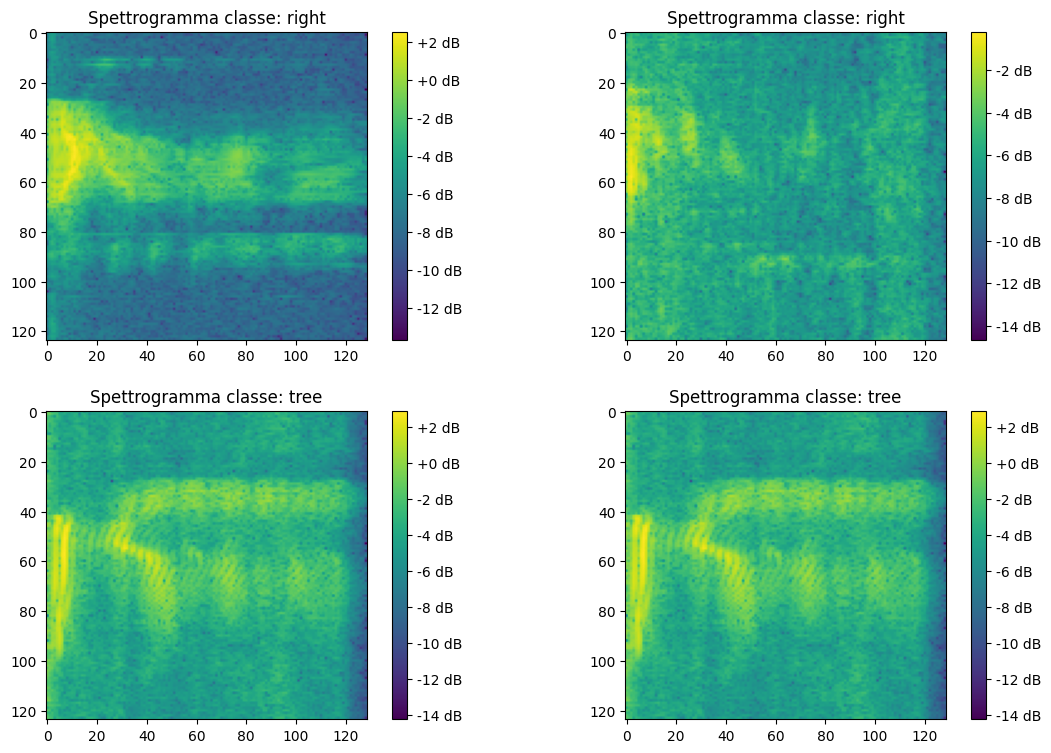

In [9]:
plot_spectrograms(train_ds)

Vengono rappresentati gli spettrogrammi di due etichette diverse. Si può notare, anche ad occhio, come comandi appartenenti ad una stessa etichette abbiano frequenze simili, mentre quelli di classi diverse presentano differenze significative.